# A comedy handbook - preliminary results and analysis

In this notebook, you will find the preliminary results and code needed for Milestone 2 of the project. This same notebook will be updated for milestone 3 as the project progresses.

The goal of this notebook is to showcase the feasability of the approaches mentionned in our report. It also contains a presentation of the various datasets we use, as well as the initial data cleaning and pre-processing done on them. 

## Imports, constants and data loading

In [222]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
import pandas as pd
import swifter # Looks unused but actually is through Monkey Patching -- don't delete
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from src.utils.data_utils import *
from src.utils.general_utils import *
from tqdm import tqdm
from prettytable import PrettyTable
from ipywidgets import interact

pd.options.mode.copy_on_write = True

In [224]:
# Constants

TEXT_SEPARATOR = "_" * 40
# The following Color Palette is color-blind friendly, as has been carefully curated from Tol and IBM's specialized palettes (https://davidmathlogic.com/colorblind/)
# You can play with it/visualize it here : https://coolors.co/332288-88ccee-e69f00-44aa99-f0e442-d55e00-882255-009e73 
COLOR_PALETTE = ["#332288","#88ccee","#e69f00","#44aa99","#f0e442","#d55e00","#882255","#009e73"]

RES_PATH = "res/"

In [225]:
# Dataset setups
RAW_DATA_FOLDER = "data/raw/"

CMU_MOVIES_DS = ProjectDataset(RAW_DATA_FOLDER+"movie.metadata.tsv",
                               "CMU Movies",
                               "Base dataset for ADA. Contains ~80K movies and their metadata.",
                               {
                                    "wikipedia_id": "A UID for the movie on Wikipedia.",
                                    "freebase_id": "A UID for the movie in Freebase (https://freebase.toolforge.org/)",
                                    "title": "The title of the movie.",
                                    "release_date": "The date the movie was officially released. (<YEAR>, or <YYYY-MM-DD>)",
                                    "box_office_revenue": "The total revenue of the movie",
                                    "runtime": "The duration of the movie, minutes (float).",
                                    "languages": "The languages spoken in the movie. Dict[<Freebase Language Identifier String>:<Language>]",
                                    "countries": "The countries where the movie was produced or primarily associated. Dict[<Freebase Country Identifier String>:<Country>]",
                                    "genres": "Movie genre(s), such as action, drama, comedy, ..."
                                }
)



CMU_CHARACTER_DS = ProjectDataset(
    RAW_DATA_FOLDER + "character.metadata.tsv",
    "CMU characters",
    "Base dataset for ADA. Contains ~450K+ characters from movies, and their descriptions.",
    {
        "wikipedia_id": "A UID for the movie the character comes from on Wikipedia.",
        "freebase_id": "A UID for the movie the character comes from on Freebase.",
        "release_date": "The release date of the movie.",
        "character_name": "The name of the character in the movie.",
        "actor_dob": "The date of birth of the actor portraying the character.",
        "actor_gender": "The gender of the actor portraying the character.",
        "actor_height": "The height of the actor portraying the character, typically in centimeters or feet.",
        "actor_ethnicity": "The ethnicity of the actor portraying the character.",
        "actor_name": "The name of the actor portraying the character.",
        "actor_age_at_release": "The age of the actor at the time the movie was released.",
        "freebase_char_actor_map_id": "A UID or mapping of the character in the Freebase FB.",
        "freebase_char_id": "A UID identifying the character portrayed by the actor in the Freebase DB.",
        "freebase_actor_id": "A UID identifying the actor in the Freebase DB."
    }
)



CMU_PLOTS_DS = ProjectDataset(RAW_DATA_FOLDER+"plot_summaries.txt",
                              "CMU plots",
                              "Base dataset for ADA. Contains a plot summary for each of the movie in the CMU Movies dataset",
                              {
                                  "wikipedia_id":"The UID corresponding to the movie",
                                  "plot": "The (summarized) plot of the movie"
                              })

MASSIVE_RT_MOVIE_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movies.csv",
                               "Massive Rotten Tomatoes Movie metadata",
                               "Dataset containing ~140K+ movies from RT",
                               {
                                    "id": "Unique identifier for each movie.",
                                    "title": "The title of the movie.",
                                    "audienceScore": "The average score given by regular viewers.",
                                    "tomatoMeter": "The percentage of positive reviews from professional critics.",
                                    "rating": "The movie's age-based classification (e.g., 'G', 'PG', 'PG-13', 'R').",
                                    "ratingContents": "Reasons for the age-based classification.",
                                    "releaseDateTheaters": "The date the movie was released in theaters.",
                                    "releaseDateStreaming": "The date the movie became available for streaming.",
                                    "runtimeMinutes": "The movie's duration in minutes.",
                                    "genre": "The movie's genre(s).",
                                    "originalLanguage": "The original language of the movie.",
                                    "director": "The director(s) of the movie.",
                                    "writer": "The writer(s) of the movie.",
                                    "boxOffice": "The total box office earnings of the movie.",
                                    "distributor": "The company responsible for distributing the movie.",
                                    "soundMix": "The sound mixing format(s) used in the movie."
                                }
                            )



RT_EXTRA_MOVIE_INFO_DS = ProjectDataset(RAW_DATA_FOLDER+"movie_info.csv",
                                        "Extra Rotten Tomatoes Movies",
                                        "Extra scraped movie information from Rotten Tomatoes for ~12K major US releases between 1970 and 2024",
                                        {
                                            "title": "The title of the movie.",
                                            "url": "RT link to the movie.",
                                            "release_date": "Release date of the movie (format is one of ['Released <DATE as text>',<YEAR>]).",
                                            "critic_score": "The rating given by professional critics.",
                                            "audience_score": "The rating given by the general audience."
                                        }
                                    )

OSCAR_AWARDS_DS = ProjectDataset(RAW_DATA_FOLDER+"the_oscar_award.csv",
                                    "Oscard Awards",
                                    "A scrape of The Academy Awards Database, recorded of past Academy Award winners and nominees between 1927 and 2024.",
                                    {
                                        "year_film": "The year the film was released.",
                                        "year_ceremony": "The year the cermenoy was held and the movie/person was nominated.",
                                        "ceremony": "The number of the ceremony.",
                                        "category": "The nomination category (e.g.: best music, documentary, writing, ...).",
                                        "name": "The name of the nominee/movie.",
                                        "film": "The title of the film for which the nominee was considered. Same as `name` whenever the whole film is nominated",
                                        "winner": "True or False, whether the nominated row won."
                                    }
                                )

ALL_DATASETS = [CMU_MOVIES_DS,CMU_CHARACTER_DS,CMU_PLOTS_DS,MASSIVE_RT_MOVIE_DS,RT_EXTRA_MOVIE_INFO_DS,OSCAR_AWARDS_DS]

In [226]:
print(f"We will use {len(ALL_DATASETS)} datasets in total, namely {', '.join(str(ds) for ds in ALL_DATASETS)}.")

We will use 6 datasets in total, namely CMU Movies, CMU characters, CMU plots, Massive Rotten Tomatoes Movie metadata, Extra Rotten Tomatoes Movies, Oscard Awards.


Here is a detailed description of what each datasets contains:


In [227]:
for i,ds in enumerate(ALL_DATASETS):
    print(f"- {number_to_emoji(i+1)} \033[4m{ds.name}\033[0m\n")
    print(f"{ds.description}\n")
    table = PrettyTable()
    table.field_names = ["Column/Fearure", "Description"]
    table.align['Description'] = 'l'
    table.max_width["Description"] = 40
    
    for column_name, column_description in ds.columns_descriptions.items():
        table.add_row([column_name, column_description+'\n'])

    print(table)
    print("\n")



- 1️⃣ CMU Movies

Base dataset for ADA. Contains ~80K movies and their metadata.

+--------------------+------------------------------------------+
|   Column/Fearure   | Description                              |
+--------------------+------------------------------------------+
|    wikipedia_id    | A UID for the movie on Wikipedia.        |
|                    |                                          |
|    freebase_id     | A UID for the movie in Freebase          |
|                    | (https://freebase.toolforge.org/)        |
|                    |                                          |
|       title        | The title of the movie.                  |
|                    |                                          |
|    release_date    | The date the movie was officially        |
|                    | released. (<YEAR>, or <YYYY-MM-DD>)      |
|                    |                                          |
| box_office_revenue | The total revenue of the movie       

In [228]:
for dataset in tqdm(ALL_DATASETS,total=len(ALL_DATASETS),desc="Preloading datasets..."):
    _ = dataset.df

Preloading datasets...: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


In [229]:
import pandas as pd
import re
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact
from IPython.display import clear_output
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact
from IPython.display import clear_output
import pandas as pd
import re
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import spacy
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [230]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.8 MB 8.3 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 10.2 MB/s eta 0:00:01
     ------------------ --------------------- 6.0/12.8 MB 10.0 MB/s eta 0:00:01
     ------------------------- -------------- 8.1/12.8 MB 10.1 MB/s eta 0:00:01
     ------------------------------- -------- 10.0/12.8 MB 9.7 MB/s eta 0:00:01
     ------------------------------------ --- 11.8/12.8 MB 9.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [231]:
def filter_comedy_movies(df):
    # Filter for comedy genre
    df_comedy = df[df['genre'].str.contains('comedy', case=False, na=False)]
    
    df_comedy = df_comedy[df_comedy['title'].notna() & (df_comedy['title'].str.strip() != "")]

    return df_comedy

### ===============================================================================================================

### CORRELATION ANALYSIS

### =======================================================================================================================

In [232]:
def data_corr_analysis():
    df_rotten_tom = MASSIVE_RT_MOVIE_DS.df
    df_rotten_com = df_rotten_tom[df_rotten_tom['genre'].str.contains('comedy', case=False, na=False)]
    filtered_rot = df_rotten_com.dropna(subset=['tomatoMeter', 'audienceScore']).copy()
    filtered_rot['boxOffice'] = filtered_rot['boxOffice'].replace(['', ' ', 'N/A', 'null', 'NaN'], np.nan)

    filtered_rot = df_rotten_com.dropna(subset=['boxOffice', 'audienceScore']).copy()
    filtered_rot['tomatoMeter'] = filtered_rot['tomatoMeter'].replace(['', ' ', 'N/A', 'null', 'NaN', 'nan'], np.nan)

    # Vérifier à nouveau et supprimer les NaN
    filtered_rot = filtered_rot.dropna(subset=[ 'tomatoMeter']).copy()
    return filtered_rot


In [233]:
def plot_audience_score_tomatoe_meter(df):

    # Create a scatter plot with a regression line
    sns.lmplot(
        data=df, 
        x='audienceScore', 
        y='tomatoMeter', 
        height=6, 
        aspect=1.5, 
        line_kws={'color': 'red'}
    )

    # Add titles and labels in English
    plt.title("Relationship between Audience Score and Tomato Meter")
    plt.xlabel("Audience Score (%)")
    plt.ylabel("Critics' Score (Tomato Meter %)")

    # Show the plot
    plt.show()


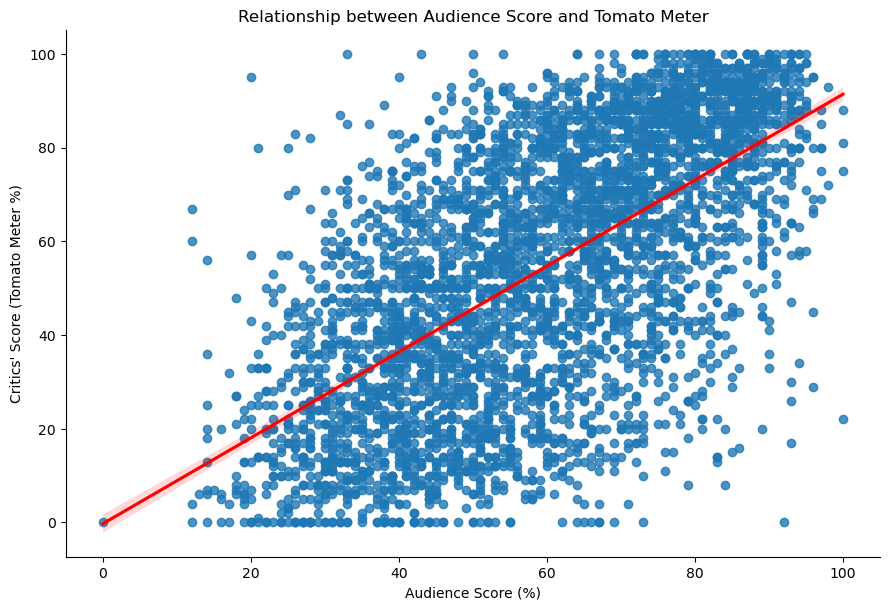

In [234]:
plot_audience_score_tomatoe_meter(data_corr_analysis())

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_audience_score_box_office(df):
    df = df[df['boxOffice'].notna()]
    df['boxOffice'] = df['boxOffice'].apply(clean_box_office)
    # Create a scatter plot with a regression line
    sns.lmplot(
        data=df, 
        x='audienceScore', 
        y='boxOffice', 
        height=6, 
        aspect=1.5, 
        line_kws={'color': 'red'}
    )

    # Set a logarithmic scale for the y-axis
    plt.yscale('log')

    # Add titles and labels in English
    plt.title("Relation between Audience Score and Box Office")
    plt.xlabel("Audience Score (%)")
    plt.ylabel("Box Office (Log Scale)")

    # Show the plot
    plt.show()


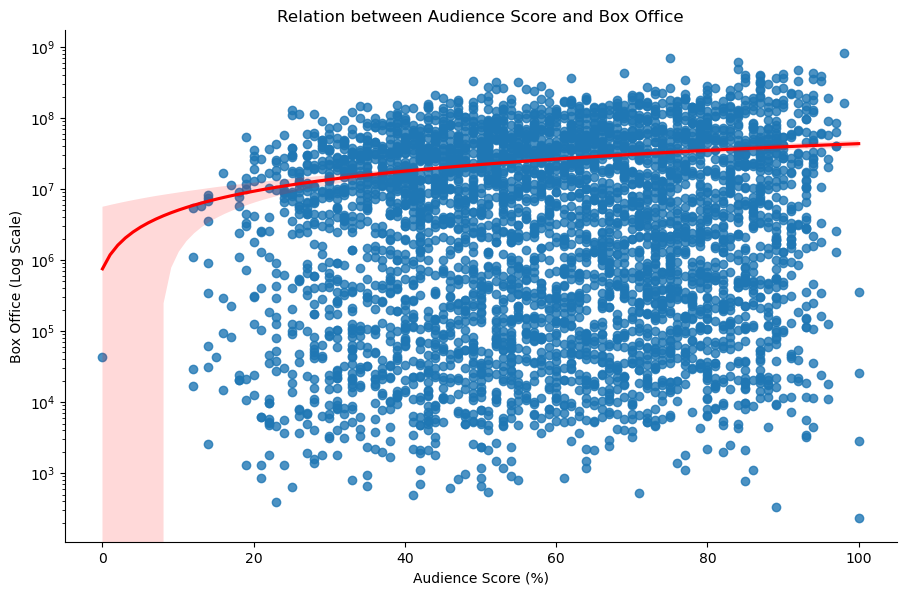

In [236]:
plot_audience_score_box_office(data_corr_analysis())

### ======================================================================================================================================================

### POPULARITY SCORE & TITLE ANALYSIS 

### ======================================================================================================================================================

In [237]:
def add_popularity_score(df, w1, w2):
    # Filtrer les lignes avec des valeurs valides
    df = df[
        df['audienceScore'].notna() & 
        df['boxOffice'].notna()
    ].copy()

    # Conversion explicite en float (au cas où)
    df['audienceScore'] = df['audienceScore'].astype(float)
    df['boxOffice'] = df['boxOffice'].astype(float)

    # Normaliser les colonnes (min-max scaling) et convertir en int
    df['audienceScore_norm'] = (
        (df['audienceScore'] - df['audienceScore'].min()) / 
        (df['audienceScore'].max() - df['audienceScore'].min())
    ).mul(100).astype(int)

    df['boxOffice_norm'] = (
        (df['boxOffice'] - df['boxOffice'].min()) / 
        (df['boxOffice'].max() - df['boxOffice'].min())
    ).mul(100).astype(int)

    # Calcul du popularity_score avec les pondérations
    df['popularity_score'] = (
        (w1 * df['audienceScore_norm'] + w2 * df['boxOffice_norm']) /
        (w1 + w2)  # Normaliser par la somme des pondérations
    ).astype(int)

    return df


In [238]:


def clean_box_office(value):
    if isinstance(value, str):
        # Supprimer le symbole '$'
        value = value.replace('$', '')
        # Si 'M' (millions), multiplier par 1,000,000
        if 'M' in value:
            value = float(value.replace('M', '')) * 1_000_000
        # Si 'K' (milliers), multiplier par 1,000
        elif 'K' in value:
            value = float(value.replace('K', '')) * 1_000
        else:
            value = float(value)  # Conversion directe si aucun suffixe
    return value


In [239]:
def init_pop_score(w1, w2):
    df_init = MASSIVE_RT_MOVIE_DS.df
    df_comedy_rot = filter_comedy_movies(df_init)
    df_comedy_rot = df_comedy_rot[df_comedy_rot['boxOffice'].notna()]
    df_comedy_rot['boxOffice'] = df_comedy_rot['boxOffice'].apply(clean_box_office)
    df_pop = add_popularity_score(df_comedy_rot, w1, w2)
    return df_pop

In [240]:
def process_titles_and_visualize_2(w1, w2):
    # Charger les données et un modèle NLP
    df = init_pop_score(w1, w2)
    nlp = spacy.load("en_core_web_sm")

    # Prétraiter les titres : nettoyer et tokeniser
    def preprocess_title(title):
        if not isinstance(title, str):  # Gérer les valeurs non string
            return []
        title = title.lower()  # Convertir en minuscule
        doc = nlp(title)  # Traiter avec spaCy
        tokens = [
            token.lemma_ for token in doc
            if not token.is_stop and not token.is_punct and token.is_alpha
        ]
        return tokens

    # Ajouter une colonne avec les titres nettoyés
    df["cleaned_title"] = df["title"].fillna("").apply(preprocess_title)

    # Compter les occurrences de chaque mot
    all_words = [word for tokens in df["cleaned_title"] for word in tokens]
    word_counts = Counter(all_words)

    # Filtrer les mots apparaissant au moins 5 fois
    filtered_words = {word: count for word, count in word_counts.items() if count >= 5}

    # Calculer les popularity scores par mot
    def calculate_popularity_scores(df, word_counts):
        word_popularity = {}
        for word in word_counts.keys():
            # Filtrer les lignes où le mot est présent dans le titre nettoyé
            relevant_scores = df[df["cleaned_title"].apply(lambda tokens: word in tokens)]["popularity_score"]
            if len(relevant_scores) > 0:
                # Moyenne des scores, arrondie à l'entier le plus proche
                word_popularity[word] = round(relevant_scores.mean())
            else:
                word_popularity[word] = 0  # Popularité à 0 si aucun film trouvé
        return word_popularity

    # Calcul des popularity scores pour les mots filtrés
    word_popularity_scores = calculate_popularity_scores(df, filtered_words)

    # Créer les vecteurs des mots en utilisant Word2Vec (via spaCy)
    unique_words = list(filtered_words.keys())
    word_vectors = [nlp(word).vector for word in unique_words]
    word_vectors = np.array(word_vectors)

    # Réduction dimensionnelle avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    word_embeddings_2d = tsne.fit_transform(word_vectors)

    # Créer un DataFrame avec les résultats
    embedding_df = pd.DataFrame({
        "word": unique_words,
        "x": word_embeddings_2d[:, 0],
        "y": word_embeddings_2d[:, 1],
        "frequency": [filtered_words[word] for word in unique_words],
        "popularity_score": [word_popularity_scores[word] for word in unique_words]
    })

    # Visualisation interactive avec Plotly
    fig = px.scatter(
        embedding_df,
        x="x",
        y="y",
        size="frequency",  # Taille des points en fonction de la fréquence
        color="popularity_score",  # Couleur en fonction du popularity_score
        hover_name="word",  # Mot affiché dans l'infobulle
        hover_data={"frequency": True, "popularity_score": True},  # Ajouter fréquence et score
        title="Word Map of Movie Titles",
        template="plotly",
        size_max=40,
        color_continuous_scale="Viridis"  # Palette de couleurs
    )

    # Personnalisation du graphique
    fig.update_traces(marker=dict(opacity=0.8))
    fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        showlegend=True,  # Montrer la légende
        hovermode="closest",
        width=1200,  # Largeur du graphique
        height=800   # Hauteur du graphique
    )

    # Afficher le graphique
    fig.show()


In [241]:
process_titles_and_visualize_2(0.5,0.5)

### ======================================================================================================================================================

### TEAM COMPOSITION ANALYSIS

### ======================================================================================================================================================

In [242]:
def merge_movie_and_character_datasets(movies_df, characters_df):
    movies_filtered = movies_df[["wikipedia_id", "title", "box_office_revenue", "genres"]]
    characters_filtered = characters_df[["wikipedia_id", "actor_name"]]
    merged_df = pd.merge(characters_filtered, movies_filtered, on="wikipedia_id")
    merged_df = merged_df[merged_df["box_office_revenue"].notnull()]
    merged_df["box_office_revenue"] = merged_df["box_office_revenue"].astype(float)
    comedies_merged_df = merged_df[merged_df["genres"].str.contains("Comedy", case=False, na=False)]
    return comedies_merged_df


In [243]:
def process_and_merge_datasets():
    cmu_characters_df = CMU_CHARACTER_DS.df
    cmu_movies_df = CMU_MOVIES_DS.df

    cmu_characters_df["wikipedia_id"] = cmu_characters_df["wikipedia_id"].astype(str)
    cmu_movies_df["wikipedia_id"] = cmu_movies_df["wikipedia_id"].astype(str)
    cmu_characters_df = cmu_characters_df[cmu_characters_df["actor_name"].apply(lambda x: isinstance(x, str) and x.strip() != "")]

    merged_df = merge_movie_and_character_datasets(cmu_movies_df, cmu_characters_df)

    merge_df_final = merged_df.copy()
    merge_df_final = merge_df_final.drop(columns=merge_df_final.columns[-1])
    merge_df_final = merge_df_final.drop_duplicates(subset=["wikipedia_id", "actor_name"])

    return merge_df_final


In [244]:
import pandas as pd
from itertools import combinations

def analyze_actor_associations(df, aggregation="mean"):
    """
    Analyze actor associations to find the most successful ones.

    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Group by movie to get actors, revenue, and title
    grouped = df_copy.groupby("wikipedia_id").agg({
        "actor_name": lambda x: list(x),
        "box_office_revenue": "first",
        "title": "first"
    }).reset_index()

    # Generate actor pairs for each movie
    actor_pairs = []
    for _, row in grouped.iterrows():
        actors = row["actor_name"]
        revenue = row["box_office_revenue"]
        title = row["title"]
        if len(actors) > 1:
            pairs = list(combinations(sorted(actors), 2))
            actor_pairs.extend([(pair[0], pair[1], revenue, title) for pair in pairs])

    # Create a DataFrame of pairs
    pairs_df = pd.DataFrame(actor_pairs, columns=["Actor1", "Actor2", "BoxOfficeRevenue", "Title"])

    # Aggregate revenue, movies, and count collaborations by actor pairs
    pair_revenue = pairs_df.groupby(["Actor1", "Actor2"]).agg({
        "BoxOfficeRevenue": aggregation,
        "Title": lambda x: list(set(x)),  # List of unique movies
    }).reset_index()

    # Add collaboration count
    pair_revenue["CollaborationCount"] = pair_revenue["Title"].apply(len)

    # Rename columns and sort results
    pair_revenue = pair_revenue.rename(columns={"BoxOfficeRevenue": f"BoxOfficeRevenue_{aggregation}", "Title": "Movies"})
    pair_revenue = pair_revenue.sort_values(by=f"BoxOfficeRevenue_{aggregation}", ascending=False)

    return pair_revenue




In [245]:
def compute_actor_pair_revenue_with_titles(df):
    """
    Calculates the average box office revenue for actor pairs who collaborated in at least two movies,
    lists the movie titles, and ranks by the number of collaborations.
    """
    # Step 1: Group by title and create actor pairs
    actor_pairs = []
    for title, group in df.groupby("title"):
        actors = group["actor_name"].tolist()
        revenue = group["box_office_revenue"].iloc[0]
        for pair in combinations(sorted(actors), 2):
            actor_pairs.append({"Actor1": pair[0], "Actor2": pair[1], "Revenue": revenue, "Title": title})

    # Convert pairs into a DataFrame
    pairs_df = pd.DataFrame(actor_pairs)

    # Step 2: Group by pairs and calculate statistics
    grouped = pairs_df.groupby(["Actor1", "Actor2"], as_index=False).agg(
        CollaborationCount=("Title", "count"),
        AverageRevenue=("Revenue", "mean"),
        Titles=("Title", lambda x: list(x))  # List movie titles
    )

    # Step 3: Filter pairs with at least two collaborations
    filtered = grouped[grouped["CollaborationCount"] > 1]

    # Step 4: Sort by CollaborationCount (descending) and then by AverageRevenue (descending)
    sorted_df = filtered.sort_values(by=["CollaborationCount", "AverageRevenue"], ascending=[False, False])

    return sorted_df


In [246]:
import plotly.graph_objects as go

def plot_actor_pair_revenue_tight(df, top_n=20):
    """
    Creates an interactive bar chart showing the average revenue for actor pairs with their names below the bars.
    Bars are tightly grouped and spaced.

    """
    # Limit to top N for readability
    top_pairs = df.head(top_n)

    # Create a combined column for actor pairs
    top_pairs["ActorPair"] = top_pairs["Actor1"] + " & " + top_pairs["Actor2"]

    # Create the plot using Plotly Graph Objects
    fig = go.Figure()

    # Add a bar for each pair
    for _, row in top_pairs.iterrows():
        fig.add_trace(go.Bar(
            x=[row["ActorPair"]],  # Show the pair as a category
            y=[row["AverageRevenue"]],
            text=f"{row['CollaborationCount']} collaborations",  # Text displayed above the bar
            textposition="outside",  # Position text above the bars
            hovertemplate=(
                f"<b>Actor Pair</b>: {row['ActorPair']}<br>"
                f"<b>Number of Collaborations</b>: {row['CollaborationCount']}<br>"
                f"<b>Average Revenue</b>: ${row['AverageRevenue']:.2f}<extra></extra>"
            ),
            name=row["ActorPair"]
        ))

    # Adjust labels and axes
    fig.update_layout(
        title="Average Revenue for Actor Pairs",
        xaxis=dict(
            title="Actor Pairs",
            tickmode="array",
            tickvals=top_pairs["ActorPair"],
            ticktext=top_pairs["ActorPair"],
            tickangle=-45  # Tilt labels to prevent overlap
        ),
        yaxis=dict(
            title="Average Revenue ($)"
        ),
        barmode="group",  # Group bars together
        template="plotly_white",
        showlegend=False,  # Hide the legend since names are on the bars
        height=700  # Increase the height of the chart
    )

    # Display the plot
    fig.show()


In [247]:
import plotly.express as px
import numpy as np

def plot_collaboration_vs_revenue_with_logscale(df):
    """
    Creates a scatter plot with a logarithmic scale for the number of collaborations
    and a jitter for low collaboration counts to improve visualization.

    Args:
        df (pd.DataFrame): DataFrame containing 'CollaborationCount' and 'AverageRevenue'.

    Returns:
        None: Displays the Plotly chart.
    """
    # Add jitter for low collaboration counts
    df["CollaborationCountJittered"] = df["CollaborationCount"] + np.random.uniform(-0.3, 0.3, size=len(df))

    # Create scatter plot
    fig = px.scatter(
        df,
        x="CollaborationCountJittered",  # Use jittered values for the x-axis
        y="AverageRevenue",
        size="CollaborationCount",  # Bubble size depends on the number of collaborations
        color="AverageRevenue",  # Color represents the revenue
        hover_data={  # Customize hover data
            "Actor1": True,
            "Actor2": True,
            "CollaborationCount": True,  # Show the original integer collaboration count
            "AverageRevenue": ":.2f",
            "CollaborationCountJittered": False  # Hide the jittered values in the hover
        },
        labels={
            "CollaborationCountJittered": "Number of Collaborations (Log Scale)",
            "AverageRevenue": "Average Box Office Revenue ($)"
        },
        title="Relationship Between Number of Collaborations and Average Box Office Revenue (Log Scale)"
    )

    # Customize the layout
    fig.update_traces(
        marker=dict(opacity=0.7, line=dict(width=1, color="DarkSlateGrey"))  # Marker styling
    )
    fig.update_layout(
        template="plotly_white",
        xaxis=dict(
            title="Number of Collaborations (Log Scale)",
            type="log",  # Apply logarithmic scale
            tickvals=[1, 2, 5, 10, 20, 50, 100],  # Custom ticks for better readability
        ),
        yaxis=dict(title="Average Box Office Revenue ($)"),
        height=600,  # Adjust the chart height
    )

    # Show the chart
    fig.show()


In [248]:
def data_for_best_2_collaboration():

    merge_df_final = process_and_merge_datasets()
    actor_revenue_stats_with_titles = compute_actor_pair_revenue_with_titles(merge_df_final)
    collaboration_df= actor_revenue_stats_with_titles[actor_revenue_stats_with_titles['CollaborationCount'] == 2]
    return collaboration_df



In [249]:
plot_actor_pair_revenue_tight(data_for_best_2_collaboration(), top_n=10)


In [250]:
plot_actor_pair_revenue_tight(actor_revenue_stats_with_titles, top_n=10)

In [251]:
plot_collaboration_vs_revenue_with_logscale(actor_revenue_stats_with_titles)


### ==================================================================================================================================================================

### TITLE COMPOSITION ANALYSIS

### ==================================================================================================================================================================

In [252]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import spacy
from collections import Counter
import plotly.express as px

def process_titles_and_visualize():
    # Load an NLP model to obtain word embeddings
    df = filter_comedy_movies(MASSIVE_RT_MOVIE_DS.df)
    nlp = spacy.load("en_core_web_sm")

    # Clean titles: remove punctuation, stopwords, and tokenize
    def preprocess_title(title):
        if not isinstance(title, str):  # Handle non-string values
            return []
        title = title.lower()  # Convert to lowercase
        doc = nlp(title)  # Process the title with spaCy
        tokens = [
            token.lemma_ for token in doc
            if not token.is_stop and not token.is_punct and token.is_alpha
        ]
        return tokens

    # Apply preprocessing
    df["cleaned_title"] = df["title"].fillna("").apply(preprocess_title)

    # Count words
    all_words = [word for tokens in df["cleaned_title"] for word in tokens]
    word_counts = Counter(all_words)

    # Filter words that appear at least 5 times
    filtered_words = {word: count for word, count in word_counts.items() if count >= 5}

    # Transform filtered words into vectors using Word2Vec (via spaCy)
    unique_words = list(filtered_words.keys())
    word_vectors = [nlp(word).vector for word in unique_words]

    # Convert word_vectors to a NumPy array
    word_vectors = np.array(word_vectors)

    # Dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)  # Adjusted perplexity
    word_embeddings_2d = tsne.fit_transform(word_vectors)

    # Stretch y-axis
    word_embeddings_2d[:, 1] *= 2  # Stretch y-axis values

    # Create a DataFrame with the results
    embedding_df = pd.DataFrame({
        "word": unique_words,
        "x": word_embeddings_2d[:, 0],
        "y": word_embeddings_2d[:, 1],
        "frequency": [filtered_words[word] for word in unique_words]
    })

    # Interactive visualization with Plotly
    fig = px.scatter(
    embedding_df,
    x="x",
    y="y",
    size="frequency",
    hover_name="word",
    title="Word Map of Movie Titles",
    template="plotly",
    size_max=40
)
    fig.update_traces(marker=dict(opacity=0.8))
    fig.update_layout(
        height=800,  # Ajustez cette valeur pour augmenter la hauteur
        xaxis_title="",
        yaxis_title="",
        showlegend=False,
        hovermode="closest"
    )
    fig.show()

In [253]:

process_titles_and_visualize()

### ========================================================================================================================================


### SEQUEL ANALYSIS

### ========================================================================================================================================


In [254]:

def filter_comedy_movies_sequels():
    """
    Filters comedy movies and their sequels based on specific conditions.
    
    Parameters:
        movie_df (pd.DataFrame): Input DataFrame with movie data.
        
    Returns:
        pd.DataFrame: Filtered DataFrame.
        set: Set of retained base IDs.
    """
    # Filter for comedy genre
    df_comedy = filter_comedy_movies(MASSIVE_RT_MOVIE_DS.df)

    df_titles_ratings = df_comedy[['id', 'title', 'audienceScore', 'releaseDateStreaming']].copy()
    df_titles_ratings_sorted = (
        df_titles_ratings
        .sort_values(by='id', ascending=True)
        .reset_index(drop=True)
        .dropna(subset=['audienceScore'])
    )


    # Filter IDs ending with "_10" or "_[2-9]"
    df_ids_between_1_and_10 = df_titles_ratings_sorted[
        df_titles_ratings_sorted['id'].str.contains(r'_(10|[2-9])$', na=False)
    ]

    df_result = df_ids_between_1_and_10.copy()
    set_base = set()

    for full_id in df_ids_between_1_and_10['id']:
        if full_id.endswith("_2"):
            base_id_match = re.match(r'^(.*)_\d+$', full_id)
            if base_id_match:
                base_id = base_id_match.group(1)
                if not df_titles_ratings_sorted['id'].str.contains(f'^{base_id}$', na=False).any():
                    df_result = df_result[~df_result['id'].str.startswith(f'{base_id}_')]
                else:
                    if base_id in df_titles_ratings_sorted['id'].values:
                        set_base.add(base_id)
                        matching_record = df_titles_ratings_sorted[df_titles_ratings_sorted['id'] == base_id]
                        df_result = pd.concat([df_result, matching_record])

    set_base.discard('no_manches_frida')
    df_result = df_result.sort_values(by='id').reset_index(drop=True)

    return df_result, set_base


In [255]:
def filter_dataframe(df, initial_bases):
    indices_to_drop = []

    for i in df.index:
        full_id = df.loc[i, 'id']
        last_char = full_id[-1]
        before_last_char = full_id[-2] if len(full_id) > 1 else ""

        if last_char.isdigit() and before_last_char == "_":
            number = int(last_char)
            base = full_id[:-2]

            if number == 2 and base not in initial_bases:
                indices_to_drop.append(i)
                continue

            if number > 2:
                if base not in initial_bases:
                    indices_to_drop.append(i)
                    continue

                expected_previous_id = f"{base}_{number - 1}"
                if i == 0 or df.loc[i - 1, 'id'] != expected_previous_id:
                    indices_to_drop.append(i)
        else:
            if full_id not in initial_bases:
                indices_to_drop.append(i)

    df.drop(index=indices_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


In [256]:
def extract_base_and_sequel(id_str):
    if len(id_str) > 2 and id_str[-1].isdigit() and id_str[-2] == "_":
        base_id = id_str[:-2]
        sequel_number = int(id_str[-1])
    else:
        base_id = id_str
        sequel_number = 1
    return pd.Series([base_id, sequel_number], index=["base_id", "sequel_number"])



In [257]:
def data_part_1():

    df_result, set_base = filter_comedy_movies_sequels()
    
    final_df = filter_dataframe(df_result, set_base)
    df_with_sequels = final_df.copy()
    df_with_sequels[["base_id", "sequel_number"]] = df_with_sequels["id"].apply(extract_base_and_sequel)



    set_titles = set(final_df[final_df['id'].isin(set_base)]['title'])
    
    return df_with_sequels, set_titles




In [258]:

def plot_movie_suites(selected_title):
    # Clear previous output to avoid multiple graphs
    clear_output(wait=True)
    
    # Retrieve the base ID corresponding to the selected title
    base_row = final_df[final_df['title'] == selected_title]
    if base_row.empty:
        print(f"Movie title '{selected_title}' not found in the dataset.")
        return
    
    base_id = base_row.iloc[0]['base_id']  # Retrieve the base_id
    
    # Filter sequels based on the same base_id
    filtered_df = final_df[final_df['base_id'] == base_id].copy()
    if filtered_df.empty:
        print(f"No sequels found for '{selected_title}' in the dataset.")
        return
    
    # Sort by sequel_number to ensure logical order
    filtered_df = filtered_df.sort_values(by="sequel_number")
    
    # Add a "year" column extracted from "releaseDateStreaming"
    filtered_df['year'] = pd.to_datetime(filtered_df['releaseDateStreaming'], errors='coerce').dt.year
    
    # Check if valid years exist
    valid_filtered_df = filtered_df.dropna(subset=['year'])
    
    # Create the graph
    fig = go.Figure()
    if valid_filtered_df.empty:
        print(f"No valid release dates for '{selected_title}', but audience scores will be shown.")
    
    # Use years if available, otherwise use titles only
    x_labels = (
        valid_filtered_df['title'] + " (" + valid_filtered_df['year'].astype(int).astype(str) + ")"
        if not valid_filtered_df.empty
        else filtered_df['title']
    )
    
    fig.add_trace(go.Scatter(
        x=x_labels,
        y=filtered_df['audienceScore'],  # Audience scores
        mode='lines+markers',
        name=selected_title,
        line=dict(color='royalblue', width=3),
        marker=dict(size=10, color='orange', line=dict(width=2, color='darkblue'))
    ))
    
    # Add annotations for each score
    for i, row in filtered_df.iterrows():
        label = (
            row['title'] + f" ({int(row['year'])})" if pd.notna(row['year']) else row['title']
        )
        fig.add_annotation(
            x=label,
            y=row['audienceScore'],
            text=str(int(row['audienceScore'])),
            showarrow=False,
            font=dict(size=12, color="black"),
            bgcolor="lightyellow",
            bordercolor="black"
        )
    
    # Add labels and style
    fig.update_layout(
        title=dict(
            text=f"<b>Audience Scores for '{selected_title}' and Its Sequels</b>",
            font=dict(size=18, color="darkblue"),
            x=0.5
        ),
        xaxis=dict(
            title="Movie Titles (Release Year if available)",
            titlefont=dict(size=14, color="darkblue"),
            tickangle=45,
            tickfont=dict(size=12, color="black")
        ),
        yaxis=dict(
            title="Audience Score",
            titlefont=dict(size=14, color="darkblue"),
            tickfont=dict(size=12, color="black"),
            gridcolor="lightgrey"
        ),
        plot_bgcolor="whitesmoke",
        template="plotly_white"
    )
    
    # Display the graph
    display(fig)


In [259]:
from ipywidgets import interact

def plot_movie_suites(selected_title):
    if not selected_title:  # Ne rien afficher si aucun titre n'est sélectionné
        print("Please select a movie title.")
        return
    
    # Reste du code existant pour afficher le graphique
    # Clear previous output to avoid multiple graphs
    clear_output(wait=True)
    
    base_row = final_df[final_df['title'] == selected_title]
    if base_row.empty:
        print(f"Movie title '{selected_title}' not found in the dataset.")
        return
    
    base_id = base_row.iloc[0]['base_id']
    filtered_df = final_df[final_df['base_id'] == base_id].copy()
    if filtered_df.empty:
        print(f"No sequels found for '{selected_title}' in the dataset.")
        return
    
    filtered_df = filtered_df.sort_values(by="sequel_number")
    filtered_df['year'] = pd.to_datetime(filtered_df['releaseDateStreaming'], errors='coerce').dt.year
    valid_filtered_df = filtered_df.dropna(subset=['year'])
    fig = go.Figure()
    x_labels = (
        valid_filtered_df['title'] + " (" + valid_filtered_df['year'].astype(int).astype(str) + ")"
        if not valid_filtered_df.empty
        else filtered_df['title']
    )
    fig.add_trace(go.Scatter(
        x=x_labels,
        y=filtered_df['audienceScore'],
        mode='lines+markers',
        name=selected_title,
        line=dict(color='royalblue', width=3),
        marker=dict(size=10, color='orange', line=dict(width=2, color='darkblue'))
    ))
    for i, row in filtered_df.iterrows():
        label = row['title'] + f" ({int(row['year'])})" if pd.notna(row['year']) else row['title']
        fig.add_annotation(
            x=label,
            y=row['audienceScore'],
            text=str(int(row['audienceScore'])),
            showarrow=False,
            font=dict(size=12, color="black"),
            bgcolor="lightyellow",
            bordercolor="black"
        )
    fig.update_layout(
        title=dict(
            text=f"<b>Audience Scores for '{selected_title}' and Its Sequels</b>",
            font=dict(size=18, color="darkblue"),
            x=0.5
        ),
        xaxis=dict(
            title="Movie Titles (Release Year if available)",
            titlefont=dict(size=14, color="darkblue"),
            tickangle=45,
            tickfont=dict(size=12, color="black")
        ),
        yaxis=dict(
            title="Audience Score",
            titlefont=dict(size=14, color="darkblue"),
            tickfont=dict(size=12, color="black"),
            gridcolor="lightgrey"
        ),
        plot_bgcolor="whitesmoke",
        template="plotly_white"
    )
    display(fig)

In [260]:
final_df, set_titles = data_part_1()
# Widget interactif avec les titres dans set_titles
interact(plot_movie_suites, selected_title=[""] + sorted(list(set_titles)))

C:\Users\Caroline V\AppData\Local\Temp\ipykernel_31060\46455043.py:26: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



interactive(children=(Dropdown(description='selected_title', options=('', 'A Haunted House', 'American Pie', '…

<function __main__.plot_movie_suites(selected_title)>

In [261]:
def plot_sequel_ratings(df):
    """
    Produces a scatter plot showing the relationship between sequel number and average audience score.
    The size of the points reflects the number of movies in each sequel.

    Args:
        df (pd.DataFrame): DataFrame containing the columns 'sequel_number' and 'audienceScore'.
    """
    import matplotlib.pyplot as plt

    # Create a copy of the DataFrame
    df = df.copy()

    # Check if the required columns are present
    required_columns = {"sequel_number", "audienceScore"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

    # Group by sequel_number to calculate averages and counts
    grouped = df.groupby("sequel_number").agg(
        avg_audienceScore=("audienceScore", "mean"),
        film_count=("audienceScore", "size")
    ).reset_index()

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        grouped["sequel_number"],
        grouped["avg_audienceScore"],
        s=grouped["film_count"] * 50,  # Adjust the multiplier for point size
        alpha=0.7,
        color="blue"
    )

    # Add labels for the number of movies
    for i in range(len(grouped)):
        plt.text(
            grouped["sequel_number"][i],
            grouped["avg_audienceScore"][i] + 1,  # Offset for readability
            f'{grouped["film_count"][i]} films',
            ha="center"
        )

    # Adjust x-axis and y-axis limits to avoid clipping
    x_min = grouped["sequel_number"].min() - 0.5  # Add margin on the left
    x_max = grouped["sequel_number"].max() + 0.5  # Add margin on the right
    y_min = grouped["avg_audienceScore"].min() - 5  # Add margin below
    y_max = grouped["avg_audienceScore"].max() + 5  # Add margin above
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Set integer ticks on the x-axis
    plt.xticks(ticks=range(grouped["sequel_number"].min(), grouped["sequel_number"].max() + 1))

    # Additional plot configurations
    plt.title("Relationship Between Sequel Number and Average Audience Score", fontsize=14)
    plt.xlabel("Sequel Number", fontsize=12)
    plt.ylabel("Average Audience Score", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


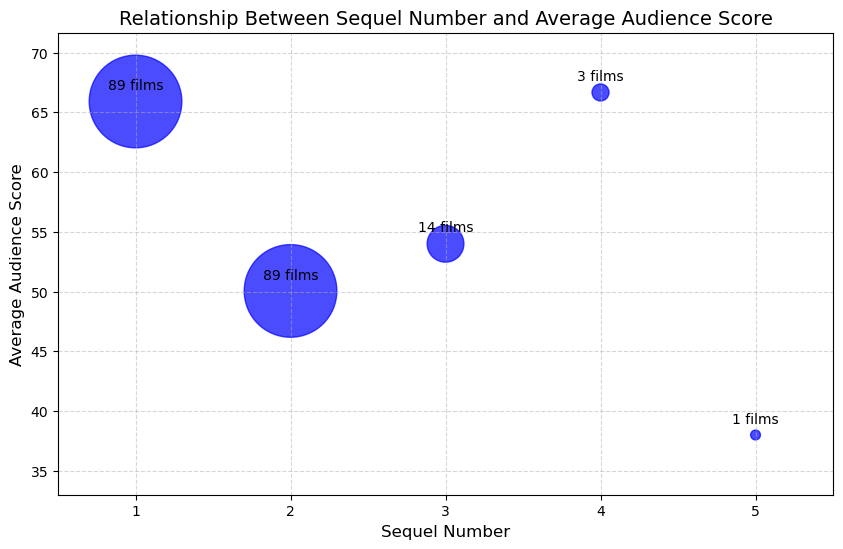

In [262]:
plot_sequel_ratings(final_df)

## Data handling

In this section, we will now show that our various approaches are feasible, by providing a small Proof of Concept for each type of approach. The results here are by no means our final results (of our final data story), but rather a intermediate viability checkpoint.

## I- Popularity analysis

##

## II. Quality analysis

In order to access useful indicators of popularity and perform our quality analysis we extend our initial dataset with several "Rotten Tomatoes" dataset. The useful indicators we want to study here are : the box-office, the expert critic reviews, the expert critic score, the movie rewards. In comparison with the popularity analysis, the reviews and scores used are the ones given by experts.
We start by selecting the useful data in each dataset and we merge appropriate datasets to asses the feasability of exploitation. The size and content of the merges enbale us to discuss the possibility to assess the next operations, for example statistical analysis.


## III. Per-genre analysis 

As this section neither requires any additional datasets, nor does it use any different type of techniques, we do no provide a sample Proof of Concept for it. The final analysis will be ready for P3! 

## IV. Cultural differences